In [45]:
import pandas as pd

####################################################################################################
### Select SSIC Hierarchical Level

# 1. 'Section'
# 2. 'Division'
# 3. 'Group'
# 4. 'Class'
# 5. 'Subclass'

level = 'Group' 
####################################################################################################

# create ssic denormalized fact table
ssic_detailed_def_filepath = r"dataSources/DoS/ssic2020-detailed-definitions.xlsx"
ssic_alpha_index_filepath = r"dataSources/DoS/ssic2020-alphabetical-index.xlsx"

df_detailed_def = pd.read_excel(ssic_detailed_def_filepath, skiprows=4)
df_alpha_index = pd.read_excel(ssic_alpha_index_filepath, dtype=str, skiprows=5)
df_alpha_index = df_alpha_index.drop(df_alpha_index.columns[2], axis=1).dropna().rename(columns={'SSIC 2020': 'SSIC 2020','SSIC 2020 Alphabetical Index Description': 'Detailed Definitions'})

df_concat = pd.concat([df_detailed_def, df_alpha_index])

####################################################################################################
### Select which fact table to train/transform
# - df_detailed_def
# - df_concat       (concat of df_detailed_def and df_alpha_index)

df_data_dict = df_detailed_def 
####################################################################################################

# prep ssic_n tables for joining/merging and reference
# Section, 1-alpha 
ssic_1_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 1)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code']) 
ssic_1_raw['Groups Classified Under this Code'] = ssic_1_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_1 = ssic_1_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_1['Groups Classified Under this Code'] = ssic_1['Groups Classified Under this Code'].str.replace('•', '')
ssic_1['Section, 2 digit code'] = ssic_1['Groups Classified Under this Code'].str[0:2]
ssic_1 = ssic_1.rename(columns={'SSIC 2020': 'Section','SSIC 2020 Title': 'Section Title'})

# Division, 2-digit
ssic_2_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 2)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_2_raw['Groups Classified Under this Code'] = ssic_2_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_2 = ssic_2_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_2['Groups Classified Under this Code'] = ssic_2['Groups Classified Under this Code'].str.replace('•', '')
ssic_2 = ssic_2.rename(columns={'SSIC 2020': 'Division','SSIC 2020 Title': 'Division Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Group, 3-digit 
ssic_3_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 3)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_3_raw['Groups Classified Under this Code'] = ssic_3_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_3 = ssic_3_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_3['Groups Classified Under this Code'] = ssic_3['Groups Classified Under this Code'].str.replace('•', '')
ssic_3 = ssic_3.rename(columns={'SSIC 2020': 'Group','SSIC 2020 Title': 'Group Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Class, 4-digit
ssic_4_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 4)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_4_raw['Groups Classified Under this Code'] = ssic_4_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_4 = ssic_4_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_4['Groups Classified Under this Code'] = ssic_4['Groups Classified Under this Code'].str.replace('•', '')
ssic_4 = ssic_4.rename(columns={'SSIC 2020': 'Class','SSIC 2020 Title': 'Class Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Sub-class, 5-digit
ssic_5 = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 5)].reset_index(drop=True).drop(columns=['Groups Classified Under this Code'])
ssic_5.replace('<Blank>', '', inplace=True)
ssic_5.replace('NaN', '', inplace=True)

# prep join columns
ssic_5['Section, 2 digit code'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Division'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Group'] = ssic_5['SSIC 2020'].astype(str).str[:3]
ssic_5['Class'] = ssic_5['SSIC 2020'].astype(str).str[:4]

# join ssic_n Hierarhical Layer Tables (Section, Division, Group, Class, Sub-Class)
ssic_df = pd.merge(ssic_5, ssic_1[['Section', 'Section Title', 'Section, 2 digit code']], on='Section, 2 digit code', how='left')
ssic_df = pd.merge(ssic_df, ssic_2[['Division', 'Division Title']], on='Division', how='left')
ssic_df = pd.merge(ssic_df, ssic_3[['Group', 'Group Title']], on='Group', how='left')
ssic_df = pd.merge(ssic_df, ssic_4[['Class', 'Class Title']], on='Class', how='left')

####################################################################################################
# mapping
level_map = {
    'Section': ('Section', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_1.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_section_classifier", ssic_1, '0'),
    'Division': ('Division', ssic_df.iloc[:, [0, 1, 6, 10, 11, 12, 13]].drop_duplicates(), ssic_2.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_division_classifier", ssic_2, ssic_1),
    'Group': ('Group', ssic_df.iloc[:, [0, 1, 7, 10, 11, 12, 13]].drop_duplicates(), ssic_3.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_group_classifier", ssic_3, ssic_2),
    'Class': ('Class', ssic_df.iloc[:, [0, 1, 8, 10, 11, 12, 13]].drop_duplicates(), ssic_4.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_class_classifier", ssic_4, ssic_3),
    'Subclass': ('Subclass', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_5.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_subclass_classifier", ssic_5, ssic_4)
}

def get_variables(level):
    # Get the tuple for the specified level
    level_tuple = level_map.get(level)
    
    # If the level is not found in the level_map, raise an exception
    if level_tuple is None:
        raise ValueError(f"Level '{level}' not found in level_map.")
    
    variable1 = level_tuple[0]  # This will be the level specified (e.g., 'Section')
    previous_level = level_tuple[-1]  # This will be the previous level in the map
    
    # Determine variable2 based on previous_level
    variable2 = None if previous_level == '0' else level_map[previous_level][0]
    
    return variable1, variable2


# Get the values for a and b based on the lvl_train
lvl_train, df_streamlit, ssic_n_sl, model, ssic_lvl, oneup_lvl = level_map.get(level, ('default_a', 'default_b', 'default_c', 'default_d', 'default_e', 'default_f'))
lvl_train_title = lvl_train + " Title"

def get_previous_level(level_map, level):
    levels = list(level_map.keys())
    current_index = levels.index(level)

    if current_index > 0:
        previous_level = levels[current_index - 1]
        return level_map[previous_level]
    else:
        return None
    
oneup_lvl_train, oneup_df_streamlit, oneup_ssic_n_sl, oneup_model, oneup_ssic_lvl, oneup_oneup_lvl = get_previous_level(level_map, level)
oneup_lvl_train_title = oneup_lvl_train + " Title"

# prep ssic_n dictionary df_prep
df_prep = ssic_df[[lvl_train, 'Detailed Definitions']]
df_prep['encoded_cat'] = df_prep[lvl_train].astype('category').cat.codes
df_prep = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()

# prep ssic_n dictionary df_prep
oneup_df_prep = ssic_df[[oneup_lvl_train, 'Detailed Definitions']]
oneup_df_prep['encoded_cat'] = oneup_df_prep[oneup_lvl_train].astype('category').cat.codes
oneup_df_prep = oneup_df_prep[[oneup_lvl_train, 'encoded_cat']].drop_duplicates()

# load model directly from huggingface
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model)
model = TFAutoModelForSequenceClassification.from_pretrained(model)

###############################################################################################################################################
# Indicate list of Top N predictions for scoring 
top_n_predictions = 15
###############################################################################################################################################

# Define the function to predict scores and categories
def predict_text(text, top_n=top_n_predictions):
    # Tokenize the input text
    predict_input = tokenizer.encode(
        text,
        truncation=True,
        padding=True,
        return_tensors="tf"
    )
    
    # Get the model output
    output = model(predict_input)[0]
    output_array = output.numpy()[0]  # Get the first (and only) output for this input

    ############################################################################################################################################### 
    
    # Get the top n scores and their corresponding categories
    top_n_indices = output_array.argsort()[-top_n:][::-1]
    top_n_scores = output_array[top_n_indices]
    top_n_categories = top_n_indices

    # Prepare the merged DataFrame
    lvl_dict = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()
    lvl_ref = ssic_lvl[[lvl_train, lvl_train_title]].drop_duplicates()
    merged_df = lvl_dict.merge(lvl_ref, on=lvl_train, how='left')

    # Create a DataFrame for the top predictions
    sorted_output_df = pd.DataFrame({
        'encoded_cat': top_n_categories,
        'value': top_n_scores
    })
    
    # Merge the top predictions with the merged DataFrame
    merged_df2 = sorted_output_df.merge(merged_df, on='encoded_cat', how='left')
    merged_df2[oneup_lvl_train] = merged_df2[lvl_train].apply(lambda x: x[:-1])

    # 1UP
    oneup_lvl_dict = oneup_df_prep[[oneup_lvl_train, 'encoded_cat']].drop_duplicates()
    oneup_lvl_ref = oneup_ssic_lvl[[oneup_lvl_train, oneup_lvl_train_title]].drop_duplicates()
    oneup_merged_df = oneup_lvl_dict.merge(oneup_lvl_ref, on=oneup_lvl_train, how='left')

    final_merged_df = merged_df2.merge(oneup_merged_df, on=oneup_lvl_train, how='left')
    
    # Return the results as a list of dictionaries
    return final_merged_df[['value', lvl_train, lvl_train_title, oneup_lvl_train, oneup_lvl_train_title]]



C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'SSIC2020 Detailed Definitions'!$A:$E.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\royle\AppData\Local\Temp\ipykernel_132

In [46]:
test_text = '''
personal systems, printers, and 3D printing solutions

'''

# Use the function to get predictions
predict_text(test_text, top_n=5)



,value,Group,Group Title,Division,Division Title
0,-0.226780,181,PRINTING AND SERVICE ACTIVITIES RELATED TO PRI...,18,PRINTING AND REPRODUCTION OF RECORDED MEDIA
1,-1.799781,329,OTHER MANUFACTURING N.E.C.,32,OTHER MANUFACTURING
2,-1.921337,261,MANUFACTURE OF ELECTRONIC COMPONENTS AND BOARDS,26,"MANUFACTURE OF COMPUTER, ELECTRONIC AND OPTICA..."
3,-2.246678,282,MANUFACTURE OF SPECIAL PURPOSE MACHINERY,28,MANUFACTURE OF MACHINERY AND EQUIPMENT
4,-2.610225,262,MANUFACTURE OF COMPUTERS AND PERIPHERAL EQUIPMENT,26,"MANUFACTURE OF COMPUTER, ELECTRONIC AND OPTICA..."


In [39]:
level_map = {
    'Section': ('Section', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_1.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_section_classifier", ssic_1, '0'),
    'Division': ('Division', ssic_df.iloc[:, [0, 1, 6, 10, 11, 12, 13]].drop_duplicates(), ssic_2.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_division_classifier", ssic_2, ssic_1),
    'Group': ('Group', ssic_df.iloc[:, [0, 1, 7, 10, 11, 12, 13]].drop_duplicates(), ssic_3.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_group_classifier", ssic_3, ssic_2),
    'Class': ('Class', ssic_df.iloc[:, [0, 1, 8, 10, 11, 12, 13]].drop_duplicates(), ssic_4.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_class_classifier", ssic_4, ssic_3),
    'Subclass': ('Subclass', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_5.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_subclass_classifier", ssic_5, ssic_4)
}

def get_previous_level(level_map, level):
    levels = list(level_map.keys())
    current_index = levels.index(level)

    if current_index > 0:
        previous_level = levels[current_index - 1]
        return level_map[previous_level]
    else:
        return None
    
# Example usage:
level = 'Class'
lvl_train, df_streamlit, ssic_n_sl, model, ssic_lvl, oneup_lvl = get_previous_level(level_map, level)
lvl_train

'Group'

In [16]:
###############################################################################################################################################
# Test, some test examples below

# specializes in the opening and management of diverse food outlets, aiming to create unique dining experiences while maintaining high standards of quality and service

# provides comprehensive Maintenance, Repair, and Overhaul (MRO) services for a wide range of aircraft, supported by a global network of facilities and strategic partnerships

# Singapore's regulatory authority overseeing business registration, financial reporting, and accounting standards, government

# Rakuten Group, Inc. is Japan's largest and the world's third-largest e-commerce company, offering diverse services from e-commerce to banking and professional sports, with global operations in Asia, Western Europe, and the Americas.

# principal activities of the Company are the manufacture of ice cream, the operation of Swensen s ice cream parlours cum restaurants, operation of other specialty restaurants and investment holding. The principal activities of the subsidiaries are shown in Note 15. 2 Summary of significant accounting policies	

###############################################################################################################################################
# Input text into test_text variable

test_text = '''
personal systems, printers, and 3D printing solutions

'''

###############################################################################################################################################

predict_input = loaded_tokenizer.encode(test_text,
truncation=True,
padding=True,
return_tensors="tf")
 
output = loaded_model(predict_input)[0]

# Convert the output tensor to numpy array
# output_array = output.numpy() # Logits (+ve to -ve)
output_array = tf.nn.softmax(output, axis=-1).numpy() # Probability (0-1)

###############################################################################################################################################
# Define specific weights for the classes (example weights, for Probability)
# class_weights = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 0.5, 0.5, 1, 1, 1, 1, 1, 1, 1, 1]  
# class_weights = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] # Adjust the weights according to your classes


# Apply the class weights to the output array
weighted_output_array = output_array #* class_weights
############################################################################################################################################### 

# Create a DataFrame from the output array
sorted_output_df = pd.DataFrame(weighted_output_array.T, columns=['Score']).sort_values(by='Score', ascending=False)
sorted_output_df.reset_index(inplace=True)

# Rename columns for clarity
sorted_output_df.columns = ['encoded_cat', 'Value']

lvl_train = 'Section'

# Conditional statements based on lvl_train
if lvl_train == 'Section':
    ssic_lvl = ssic_1
elif lvl_train == 'Division':
    ssic_lvl = ssic_2
elif lvl_train == 'Group':
    ssic_lvl = ssic_3
elif lvl_train == 'Class':
    ssic_lvl = ssic_4
elif lvl_train == 'SSIC 2020':
    ssic_lvl = ssic_5

# need to load ssic_df and df
lvl_dict = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()
lvl_ref = ssic_lvl[[lvl_train, lvl_train_title]].drop_duplicates()
merged_df = lvl_dict.merge(lvl_ref, on= lvl_train, how='left')
merged_df2 = sorted_output_df.merge(merged_df, on = 'encoded_cat', how='left')

merged_df2[['Value', lvl_train, lvl_train_title]].head(15)

,Value,Section,Section Title
0,0.964116,C,MANUFACTURING
1,0.006419,J,INFORMATION AND COMMUNICATIONS
2,0.006137,M,"PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES"
3,0.005052,N,ADMINISTRATIVE AND SUPPORT SERVICE ACTIVITIES
4,0.004417,F,CONSTRUCTION
5,0.003695,S,OTHER SERVICE ACTIVITIES
6,0.002408,G,WHOLESALE AND RETAIL TRADE
7,0.002263,H,TRANSPORTATION AND STORAGE
8,0.001677,K,FINANCIAL AND INSURANCE ACTIVITIES
9,0.000589,A,AGRICULTURE AND FISHING


In [49]:
df_prep

,Section,encoded_cat
0,A,0
32,B,1
37,C,2
392,D,3
400,E,4
406,F,5
447,G,6
615,H,7
668,I,8
680,J,9


In [17]:
###############################################################################################################################################
# Test with List of 102

import pandas as pd
import os

# Ingest & Convert SSIC Detailed Definition Doc into df
# Get current directory
current_dir = os.getcwd()

# Get parent directory
parent_dir = os.path.dirname(current_dir)

list_102 = "Webscrap\List of 90 Coy and SSIC.csv"
list_102_AR_filename = "Webscrap\AR Report Data\extracted_notes_pages_with_uen.xlsx"

list_102_filepath = os.path.join(parent_dir, list_102)
list_102_AR_filepath = os.path.join(parent_dir, list_102_AR_filename)

df_list_102 = pd.read_csv(list_102_filepath, dtype = str)
df_list_102_AR = pd.read_excel(list_102_AR_filepath, dtype = str)

df_list_102_merged = pd.merge(df_list_102, df_list_102_AR, left_on='UEN', right_on='UEN Number')

# ssic_code 1
df_list_102_merged['Division'] = df_list_102_merged['ssic_code'].astype(str).str[:2]
df_list_102_merged['Group'] = df_list_102_merged['ssic_code'].astype(str).str[:3]
df_list_102_merged['Class'] = df_list_102_merged['ssic_code'].astype(str).str[:4]
df_list_102_merged['Sub-class'] = df_list_102_merged['ssic_code'].astype(str).str[:5]
df_list_102_merged = pd.merge(df_list_102_merged, ssic_1[['Section, 2 digit code', 'Section']], left_on='Division', right_on='Section, 2 digit code', how='left')
df_list_102_merged.drop(columns=['Section, 2 digit code'], inplace=True)

# ssic_code 2
df_list_102_merged['Division2'] = df_list_102_merged['ssic_code2'].astype(str).str[:2]
df_list_102_merged['Group2'] = df_list_102_merged['ssic_code2'].astype(str).str[:3]
df_list_102_merged['Class2'] = df_list_102_merged['ssic_code2'].astype(str).str[:4]
df_list_102_merged['Sub-class2'] = df_list_102_merged['ssic_code2'].astype(str).str[:5]
df_list_102_merged = pd.merge(df_list_102_merged, ssic_1[['Section, 2 digit code', 'Section']].rename(columns={'Section': 'Section2'}), left_on='Division2', right_on='Section, 2 digit code', how='left')
df_list_102_merged.drop(columns=['Section, 2 digit code'], inplace=True)

# df_list_102_merged[['Notes Page Content']]

###############################################################################################################################################
# TDIDF

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
nltk.download('stopwords')
import re
# nltk.download()
from nltk.corpus import stopwords

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    words_to_remove = ['principal', 'activities', 'investment', 'holding', 'holdings', 'singapore', 'exchange', 'securities', 'trading', 'limited', 'company']  # List of additional words to remove############################################################
    # Remove additional words
    if words_to_remove:
        text = ' '.join(word for word in text.split() if word not in words_to_remove)
    return text

df_list_102_merged['Notes Page Content2'] = df_list_102_merged['Notes Page Content'].apply(preprocess_text)

tfidf_vectorizer = TfidfVectorizer(
    # # max_df=0.8,         # Ignore terms that appear in more than 80% of documents
    # # min_df=2,           # Ignore terms that appear in fewer than 2 documents
    # max_features=1000,  # Consider only the top 1000 terms by TF-IDF score
    # ngram_range=(1, 2), # Include both unigrams and bigrams
    # stop_words='english' # Remove standard English stop words
)

# Fit and transform the preprocessed text ('Notes Page Content2')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_list_102_merged['Notes Page Content2'])

# Get feature names (terms)
terms = tfidf_vectorizer.get_feature_names_out()

# Set a TF-IDF threshold
tfidf_threshold = 0.1

# Function to get important terms from a document
def get_important_terms(doc_index, tfidf_matrix, terms, threshold, top_tokens=10):
    term_scores = tfidf_matrix[doc_index].toarray().flatten()
    important_term_indices = term_scores >= threshold
    
    # Filter terms based on threshold and preserve original order
    important_terms = [terms[i] for i in range(len(terms)) if important_term_indices[i]]
    
    # Retrieve original order from 'Notes Page Content2'
    original_text = df_list_102_merged.at[doc_index, 'Notes Page Content2'].split()
    important_terms_in_order = [term for term in original_text if term in important_terms]

    # Get the first 'top_tokens' tokens
    first_10_tokens = important_terms_in_order[:top_tokens]
    
    return ' '.join(first_10_tokens )

# Apply the function to each document in the DataFrame
df_list_102_merged['Notes Page Content2'] = [
    get_important_terms(i, tfidf_matrix, terms, tfidf_threshold)
    for i in range(tfidf_matrix.shape[0])
]


df_list_102_merged[['entity_name', 'Notes Page Content', 'Notes Page Content2']]
# df_list_102_merged[df_list_102_merged['entity_name'] == 'CORTINA HOLDINGS LIMITED'][['entity_name', 'Notes Page Content', 'Notes Page Content2']]
# df_list_102_merged.head() TELECHOICE INTERNATIONAL LIMITED

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\royle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,entity_name,Notes Page Content,Notes Page Content2
0,ABR HOLDINGS LIMITED,principal activities of the Company are the ma...,manufacture ice cream operation swensen ice cr...
1,ABUNDANCE INTERNATIONAL LIMITED,principal activities of the Company are those ...,print paper management related commodity chemi...
2,ABUNDANTE LIMITED,principal activities of the Company are those ...,supply ready mixed concrete manufacture sale r...
3,ACCRELIST MEDICAL AESTHETICS (SPC) PTE. LTD.,principal activities of the Company is investm...,subsidiary corporations described
4,ACESIAN PARTNERS LIMITED,principal activities of the Group consist of d...,group consist design manufacture supply critic...
...,...,...,...
79,TELECHOICE INTERNATIONAL LIMITED,principal activities of the Company during the...,wholesalers retailers suppliers importers expo...
80,TT INTERNATIONAL LIMITED,principal activities of the Company are those ...,relating retail distribution wide range furnit...
81,UNITED OVERSEAS INSURANCE LIMITED,principal activities are the underwriting 1,underwriting
82,VENTURE CORPORATION LIMITED,principal activities of the Company are to pro...,provide manufacturing product design developme...


In [7]:
df_selected_columns = df_list_102_merged[['entity_name', 'Notes Page Content', 'Notes Page Content2']]

# Save the selected columns to a CSV file
csv_file_path = 'data validation.csv'
df_selected_columns.to_csv(csv_file_path, index=False)

In [18]:
###############################################################################################################################################
# Indicate list of Top N predictions for scoring 
top_n_predictions = 15
###############################################################################################################################################

# Define the function to predict scores and categories
def predict_text(text, top_n=top_n_predictions):
    predict_input = loaded_tokenizer.encode(
        text,
        truncation=True,
        padding=True,
        return_tensors="tf"
    )
    output = loaded_model(predict_input)[0]
    output_array = output.numpy()[0]  # Get the first (and only) output for this input
    # output_array = tf.nn.softmax(output, axis=-1).numpy()[0] # Probability (0-1)

    ###############################################################################################################################################
    # Define specific weights for the classes (example weights, adjust as needed)
    # class_weights = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.1, 0.1, 0.1, 1, 1, 1, 1, 1, 1, 1, 1]  
    class_weights = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] # Adjust the weights according to your classes


    # Apply the class weights to the output array
    output_array = output_array * class_weights
    ############################################################################################################################################### 
    
    # Get the top n scores and their corresponding categories
    top_n_indices = output_array.argsort()[-top_n:][::-1]
    top_n_scores = output_array[top_n_indices]
    top_n_categories = top_n_indices
    
    return [{'value': score, 'encoded_cat': category} for score, category in zip(top_n_scores, top_n_categories)]

# Create an empty list to store the predictions
predictions = []

# Iterate over each row of the DataFrame and apply the prediction function
for idx, row in df_list_102_merged.iterrows():
    text = row['Notes Page Content2']
    result = predict_text(text)
    for pred in result:
        pred.update({
            'UEN': row['UEN'],
            'entity_name': row['entity_name'],
            'ssic_code': row['ssic_code'],
            'ssic_code2': row['ssic_code2'],
            'Notes Page Content': row['Notes Page Content'],
            'Notes Page Content2': text,
            'Layer': row[lvl_train],
            'Layer2': row[lvl_train + "2"]
        })
        predictions.append(pred)

# Create a DataFrame from the list of predictions
prediction_df = pd.DataFrame(predictions)
prediction_df = pd.merge(prediction_df, ref_df[['SSIC 2020','SSIC 2020 Title']].rename(columns={'SSIC 2020 Title': 'SSIC 2020 Title1'}), left_on='Layer', right_on='SSIC 2020', how='left')
prediction_df.drop(columns=['SSIC 2020'], inplace=True)
prediction_df = pd.merge(prediction_df, ref_df[['SSIC 2020','SSIC 2020 Title']].rename(columns={'SSIC 2020 Title': 'SSIC 2020 Title2'}), left_on='Layer2', right_on='SSIC 2020', how='left')
prediction_df.drop(columns=['SSIC 2020'], inplace=True)
prediction_df = prediction_df.merge(df_prep, on = 'encoded_cat', how = 'left')
prediction_df = prediction_df.merge(ref_df, left_on = 'Section', right_on = 'SSIC 2020', how = 'left')
prediction_df.drop(columns=['SSIC 2020'], inplace=True)
prediction_df = prediction_df.where(pd.notna(prediction_df), "Blank")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

prediction_df[prediction_df['entity_name'] == 'ANNAIK LIMITED'].head(2)

,value,encoded_cat,UEN,entity_name,ssic_code,ssic_code2,Notes Page Content,Notes Page Content2,Layer,Layer2,SSIC 2020 Title1,SSIC 2020 Title2,Section,SSIC 2020 Title
105,5.945195,10,197702066M,ANNAIK LIMITED,46620,25994,principal activity of the Company is that of investment holding. The principal activities of the subsidiaries and associates are disclosed in Notes 15 and 16 to the financial statements respectively.,activity subsidiaries associates disclosed notes financial statements respectively,G,C,WHOLESALE AND RETAIL TRADE,MANUFACTURING,K,FINANCIAL AND INSURANCE ACTIVITIES
106,1.086882,12,197702066M,ANNAIK LIMITED,46620,25994,principal activity of the Company is that of investment holding. The principal activities of the subsidiaries and associates are disclosed in Notes 15 and 16 to the financial statements respectively.,activity subsidiaries associates disclosed notes financial statements respectively,G,C,WHOLESALE AND RETAIL TRADE,MANUFACTURING,M,"PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES"


In [19]:
grouped_prediction_df = prediction_df.groupby(['entity_name', 'ssic_code', 'ssic_code2', 'Layer', 'Layer2'])[lvl_train].apply(list).reset_index()

def check_alpha_in_list(row, N):
    # Check if the alpha in the 1st column is in the first N elements of the list in the 3rd column
    if row['Layer'] in row['Section'][:N] or row['Layer2'] in row['Section'][:N]:
        return 'Y'
    else:
        return 'N'

###############################################################################################################################################
# Specify Top N Threshold
N = 3
###############################################################################################################################################

grouped_prediction_df['Within Top N'] = grouped_prediction_df.apply(check_alpha_in_list, axis=1, N=N)

# grouped_prediction_df[grouped_prediction_df['entity_name'] == 'DELFI LIMITED']

# grouped_prediction_df.head()

grouped_prediction_df[grouped_prediction_df['Within Top N'] == 'N'].reset_index(drop = True)

,entity_name,ssic_code,ssic_code2,Layer,Layer2,Section,Within Top N
0,ABUNDANTE LIMITED,23940,41009,C,F,"[G, K, L, N, F, C, S, H, M, A, I, J, O, P, B]",N
1,ADVANCED SYSTEMS AUTOMATION LIMITED,32909,Blank,C,Blank,"[K, M, L, S, N, O, G, H, J, T, Q, R, I, A, B]",N
2,ALLIANCE HEALTHCARE GROUP LIMITED,86909,86201,Q,Q,"[K, M, L, S, N, H, O, J, G, Q, R, I, T, P, A]",N
3,ANNAIK LIMITED,46620,25994,G,C,"[K, M, L, S, H, N, J, O, G, Q, I, A, R, T, P]",N
4,AP OIL INTERNATIONAL LIMITED,19202,46610,C,G,"[K, M, L, S, H, N, J, O, G, Q, I, A, T, B, R]",N
5,CITY DEVELOPMENTS LIMITED,68101,64202,L,K,"[M, S, R, K, F, N, O, P, Q, J, L, C, A, H, I]",N
6,CORTINA HOLDINGS LIMITED,70209,64202,M,K,"[G, L, N, K, M, S, I, H, O, Q, R, J, A, F, C]",N
7,CREATIVE TECHNOLOGY LTD.,82999,Blank,N,Blank,"[K, M, L, S, O, N, Q, R, H, P, G, J, F, I, T]",N
8,CSE GLOBAL LIMITED,82999,43909,N,F,"[J, M, R, N, K, S, H, F, C, G, P, O, Q, A, I]",N
9,HOTEL GRAND CENTRAL LIMITED,55101,Blank,I,Blank,"[K, M, L, O, S, N, I, H, Q, R, T, G, J, A, P]",N


In [20]:
# Rank the predictions within each UEN group
prediction_df['Rank'] = prediction_df.groupby('entity_name').cumcount() + 1

def calculate_score(row, top_n_predictions):
    if row['Rank'] <= top_n_predictions:
        if row['Layer'] == row[lvl_train]:
            rank = row['Rank']
            if rank == 1:
                return 0
            else:
                return round((rank - 1) / top_n_predictions,2)
    return 1

def calculate_score2(row, top_n_predictions):
    if pd.isnull(row['Layer2']) or row['Layer2'] == 'Blank' :
        return None
    
    if row['Rank'] <= top_n_predictions:
        if row['Layer2'] == row[lvl_train]:
            rank = row['Rank']
            if rank == 1:
                return 0
            else:
                return round((rank - 1) / top_n_predictions,2)
    return 1

###############################################################################################################################################
# Exponential Scoring
def ecalculate_score(row, top_n_predictions):
    if row['Rank'] <= top_n_predictions and row['Layer'] == row[lvl_train]:
        rank = row['Rank']
        if rank == 1:
            return 0
        else:
            # Exponential transformation
            score = 1 - (1 - 0.1) ** (rank - 1)
            # score = (rank - 1) ** 2 / (top_n_predictions - 1) ** 2
            return round(score, 2)
    return 1

def ecalculate_score2(row, top_n_predictions):
    if pd.isnull(row['Layer2']) or row['Layer2'] == 'Blank':
        return None
    
    if row['Rank'] <= top_n_predictions and row['Layer2'] == row[lvl_train]:
        rank = row['Rank']
        if rank == 1:
            return 0
        else:
            # Exponential transformation
            score = 1 - (1 - 0.1) ** (rank - 1)
            # score = (rank - 1) ** 2 / (top_n_predictions - 1) ** 2
            return round(score, 2)
    return 1


prediction_df['score'] = prediction_df.apply(ecalculate_score, axis=1, args=(top_n_predictions,)) # Toggle ecal or cal
prediction_df['score2'] = prediction_df.apply(ecalculate_score2, axis=1, args=(top_n_predictions,)) # Toggle ecal or cal

# prediction_df

# Find the minimum score for each UEN
score_prediction_df = prediction_df.groupby(['entity_name']).agg({'score': 'min', 'score2': 'min'}).reset_index()

###############################################################################################################################################
# Specify Weightage for Primary and Secondary SSIC
p_weight = 1
s_weight = 0.5

score_prediction_df['t_score'] = round((score_prediction_df['score'] * p_weight + score_prediction_df['score2'].fillna(0) * s_weight) / (p_weight + (score_prediction_df['score2'].notnull() * s_weight)),2)
###############################################################################################################################################

# prediction_df = pd.merge(prediction_df, ref_df[['SSIC 2020','SSIC 2020 Title']].rename(columns={'SSIC 2020 Title': 'SSIC 2020 Title1'}), left_on='Layer', right_on='SSIC 2020', how='left')
score_prediction_df = pd.merge(score_prediction_df, grouped_prediction_df[['entity_name', 'Within Top N']], left_on='entity_name', right_on='entity_name', how='left')

###############################################################################################################################################
# Calculate the number of rows to select (top 10%)
n = 0.5  # 10% (you can adjust this percentage as needed)
top_n_rows = int(len(score_prediction_df) * n)

score_prediction_df.sort_values(by = 't_score', ascending = False).reset_index(drop=True).nlargest(top_n_rows, 't_score') # Toggle method nsmallest and nlargest


,entity_name,score,score2,t_score,Within Top N
0,ADVANCED SYSTEMS AUTOMATION LIMITED,1.00,NaN,1.00,N
1,OSSIA INTERNATIONAL LIMITED,1.00,1.00,1.00,N
2,AP OIL INTERNATIONAL LIMITED,1.00,0.57,0.86,N
3,SBI OFFSHORE LIMITED,0.75,0.75,0.75,N
4,ANNAIK LIMITED,0.57,1.00,0.71,N
5,VENTURE CORPORATION LIMITED,0.69,NaN,0.69,N
6,LEY CHOON GROUP HOLDINGS LIMITED,1.00,0.00,0.67,Y
7,MEGACHEM LIMITED,0.75,0.52,0.67,N
8,TAI SIN ELECTRIC LIMITED,1.00,0.00,0.67,Y
9,ALLIANCE HEALTHCARE GROUP LIMITED,0.61,0.61,0.61,N


In [22]:
# Save the selected columns to a CSV file
csv_file_path = 'data validation.csv'
score_prediction_df.to_csv(csv_file_path, index=False)


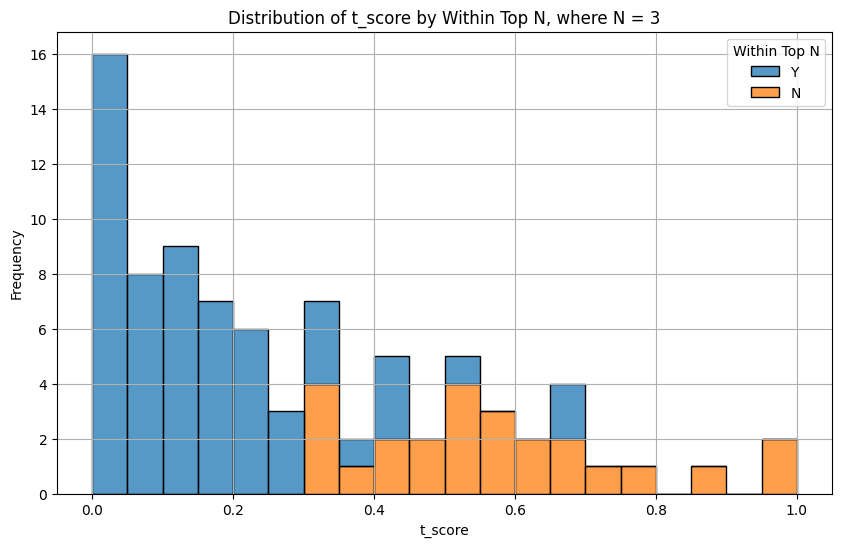

% in Top N: 70.24%
% not in Top N: 29.76%


In [59]:
# !pip install seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of t_score colored by category
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size

# Histogram plot with Seaborn
sns.histplot(data=score_prediction_df, x='t_score', hue='Within Top N', multiple='stack', bins=20, edgecolor='black')  # Adjust bins as needed
plt.title('Distribution of t_score by Within Top N, where N = ' + str(N))  # Optional: Add plot title
plt.xlabel('t_score')  # Optional: Add x-axis label
plt.ylabel('Frequency')  # Optional: Add y-axis label

plt.grid(True)  # Optional: Add grid
plt.show()


# Calculate percentage of rows where column 'B' equals 'N'
count_A_equals_Y = len(score_prediction_df[score_prediction_df['Within Top N'] == 'Y'])
percentage_A_equals_Y = (count_A_equals_Y / len(score_prediction_df)) * 100
count_B_equals_N = len(score_prediction_df[score_prediction_df['Within Top N'] == 'N'])
percentage_B_equals_N = (count_B_equals_N / len(score_prediction_df)) * 100

print(f"% in Top N: {percentage_A_equals_Y:.2f}%")
print(f"% not in Top N: {percentage_B_equals_N:.2f}%")